In [33]:
import os
os.chdir('/home/shashank/Documents/code/diff-dope/')
import matplotlib.pyplot as plt
import hydra
from icecream import ic
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
import numpy as np
from theseus.geometry import SO3
import torch
import pybullet as p
from scipy.spatial.transform import Rotation
import diffdope as dd
from diffdope.pcd_utils import *
from diffdope import *
import math
import meshcat
import meshcat.geometry as mcg
from typing import List, Tuple
import cv2
cname = "myscene_dope"
with initialize(version_base=None, config_path="../configs/"):
    cfg = compose(config_name=cname)

In [34]:
torch.manual_seed(42)
sigma_r = 1.0
sigma_t = 0.0

In [35]:
def noise_pose(gt_pos,gt_rot,sigma_t,sigma_r):
    p = torch.from_numpy(gt_pos).float()
    R = torch.from_numpy(Rotation.from_quat(gt_rot).as_matrix()).float()
    nr = torch.randn(1,3) * sigma_r
    nR = torch.matmul(R,SO3().exp_map(nr).to_matrix())
    nP = torch.randn_like(p) * sigma_t + p
    npose = np.zeros((7,))
    npose[:3] = nP.numpy()
    npose[3:] = Rotation.from_matrix(nR.numpy()).as_quat()
    return npose

def pose_to_T44(p,q):
    t = np.eye(4)
    t[:3,-1] = p
    t[:3,:3] = Rotation.from_quat(q).as_matrix()
    return t
def T44_to_pose(T):
    pose = np.zeros((7,))
    pose[:3] = T[:3,-1]
    pose[3:] = Rotation.from_matrix(T[:3,:3]).as_quat()
    return pose

qgt = Rotation.from_matrix(np.array([-0.7913458966114294, 0.07584660081839613, 0.6066456668109877, 0.46529349746608056, 0.7183778584745024, 0.5171413865369608, -0.39657739866517305,
        0.6915059982370961, -0.6037763006860087]).reshape(3,3)).as_quat()
pgt = np.array([-161.16877980209404, 206.22094040904116, 747.151333695172])
pnoi = noise_pose(pgt,qgt,0.0,0.8)
cfg['object3d']['position'] = pnoi[:3].tolist()
cfg['object3d']['rotation'] = pnoi[3:].tolist()

### For our data

{1: 'tray', 2: '006_mustard_bottle', 3: '003_cracker_box', 4: '004_sugar_box', 5: '019_pitcher_base', 6: '025_mug', 7: '009_gelatin_box', 8: '040_large_marker', 9: '037_scissors', 10: '005_tomato_soup_can', 11: '004_sugar_box'}


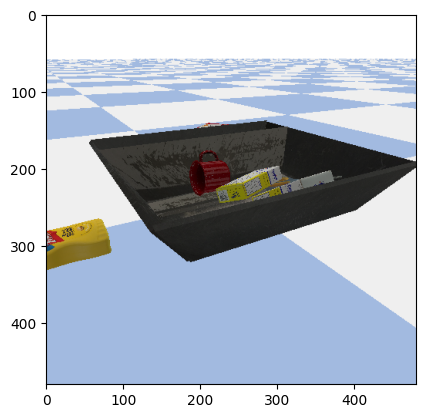

In [36]:
parent_id = '201'
file_path = '/home/shashank/code/packages/rpdiff/src/rpdiff/data/task_demos/cluttered_tabletop/0/'
dfile = np.load(file_path + f'{parent_id}.npz',allow_pickle=True)[parent_id].item()
print(dfile['objects'])
plt.imshow(dfile['img_arr'][0])

In [37]:
object_id = 2
object_name = dfile['objects'][object_id]

In [38]:
camera_info = dfile['camera_info']
view_matrix = p.computeViewMatrix(camera_info['cam_eye'],camera_info['lookat'],camera_info['up'])
view_matrix = np.asarray(view_matrix,order='F').reshape([4,4],order='F')
poses = dfile['poses']
gt_pose_world = np.array(poses[object_name])[0]
gt_pose_world = pose_to_T44(gt_pose_world[:3],gt_pose_world[3:])
gt_pose_cam_t44 = np.matmul(view_matrix,gt_pose_world)
gt_pose_cam_rtheta = SO3(tensor=torch.from_numpy(gt_pose_cam_t44[:3,:3]).unsqueeze(0)).log_map().squeeze()
gt_pose_cam = T44_to_pose(gt_pose_cam_t44)
print(f'GT Camera Frame position:{gt_pose_cam[:3]}')
print(f'GT Camera Frame Orientation: {gt_pose_cam[3:]}')
print(f'GT Camera Frame rtheta: {gt_pose_cam_rtheta}')

noised_pose = noise_pose(gt_pose_cam[:3],gt_pose_cam[3:],sigma_t,sigma_r)
position = noised_pose[:3]
rotation = noised_pose[3:]
print(f'Noised Position: {position}')
print(f'Noised Rotation: {rotation}')

GT Camera Frame position:[-0.3136427  -0.08476402 -0.5803759 ]
GT Camera Frame Orientation: [ 0.08059301 -0.51111406  0.07089703  0.85278415]
GT Camera Frame rtheta: tensor([ 0.1696, -1.0755,  0.1492], dtype=torch.float64)
Noised Position: [-0.31364271 -0.08476402 -0.58037591]
Noised Rotation: [ 0.15720682 -0.44237565  0.25900168  0.84410185]


In [39]:
cfg['camera']['im_height'] = camera_info['height']
cfg['camera']['im_width'] = camera_info['width']
cfg['camera']['znear'] = camera_info['nearVal'] 
cfg['camera']['zfar'] = camera_info['farVal']
cfg['camera']['fov'] = camera_info['fov']
###########################################
cfg['object3d']['position'] = position.tolist()
cfg['object3d']['rotation'] = rotation.tolist()
###########################################
cfg['scene']['dataset_path'] = file_path
cfg['scene']['parent_id'] = parent_id
cfg['scene']['object_id'] = object_id
cfg['scene']['image_resize'] = 1.0
cfg['object3d']['model_path'] = f'/home/shashank/code/packages/rpdiff/src/rpdiff/assets/ycb/{object_name}/textured_simple.obj'
############################################
cfg['render_images']['crop_around_mask'] = True
#############################################
cfg['losses']['l1_rgb_with_mask']= True
cfg['losses']['weight_rgb']= 10.0
cfg['losses']['l1_depth_with_mask']= True
cfg['losses']['weight_depth']= 10.0
cfg['losses']['l1_mask']= True
cfg['losses']['weight_mask']= 10.0
cfg['losses']['l1_reconstruct_depth_with_mask']= False
cfg['losses']['weight_reconstruct']= 0.0
###############################################

cfg['hyperparameters']['nb_iterations'] = 150
cfg['hyperparameters']['batchsize'] = 16
cfg['hyperparameters']['base_lr'] = 2
cfg['hyperparameters']['learning_rate_base'] = 2
cfg['hyperparameters']['learning_rates_bound'] = [0.01, 2]
cfg['hyperparameters']['lr_decay'] = 0.5

#### Calculate losses at the ground-truth pose

[1.356522903859074, 0.29229190282506584, 0.1263982745235099, 1.0961340141647096, 0.08017851197753519, 0.15351355407241793, 0.8750142747734202, 0.23201900327950672, 0.6093748637613127, 1.071360118451702, 0.9908377295071352, 0.9675161856796058, 1.6360687772245674, 0.8718536078565641, 0.41459060728356767, 1.9379472598819496]
Loss at Ground Truth:
GT Raw RGB Loss:0.02856307663023472
GT Raw Depth Loss:0.00017798140470404178
GT Raw Reconstruction Loss:0.00017798140470404178
GT Raw Mask Loss:0.004298307001590729


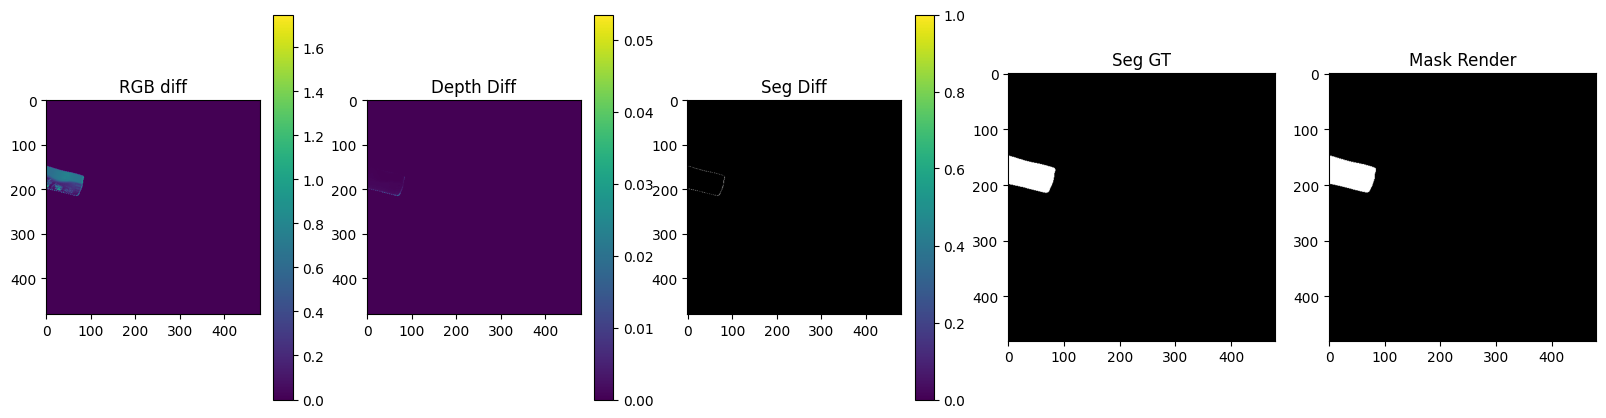

In [40]:
cfg_gt = cfg.copy()
cfg_gt['object3d']['position'] = gt_pose_cam[:3].tolist()
cfg_gt['object3d']['rotation'] = gt_pose_cam[3:].tolist()
ddope_gt = dd.DiffDope(cfg=cfg_gt)
ddope_gt.gt_tensors["rgb"] = ddope_gt.scene.tensor_rgb.img_tensor
ddope_gt.gt_tensors["depth"] = ddope_gt.scene.tensor_depth.img_tensor
ddope_gt.gt_tensors["segmentation"] = ddope_gt.scene.tensor_segmentation.img_tensor

result = ddope_gt.object3d()

mtx_gu = dd.matrix_batch_44_from_position_r(
    p=result['trans'], r=result['rtheta']
)
ddope_gt.renders = dd.render_texture_batch(
    glctx=ddope_gt.glctx,
    proj_cam=ddope_gt.camera.cam_proj,
    mtx=mtx_gu,
    pos=result["pos"],
    pos_idx=result["pos_idx"],
    uv=result["uv"],
    uv_idx=result["uv_idx"],
    tex=result["tex"],
    resolution=ddope_gt.resolution,
)
losses = ['rgb','depth','mask']
loss = torch.zeros(1).cuda()
to_add = {}
to_add["rgb"] = ddope_gt.renders["rgb"].detach().cpu()
to_add["depth"] = ddope_gt.renders["depth"].detach().cpu()
to_add["mtx"] = mtx_gu.detach().cpu()
ddope_gt.optimization_results.append(to_add)
print("Loss at Ground Truth:")
for i,loss_function in enumerate(ddope_gt.loss_functions):
    l = loss_function(ddope_gt)
    if l is None:
        continue
    loss += l

gt_rgb_loss = ddope_gt.losses_values['rgb'].squeeze()[0]
gt_depth_loss = ddope_gt.losses_values['depth'].squeeze()[0]
gt_reconstruct_loss = ddope_gt.losses_values['depth'].squeeze()[0]
gt_mask_loss = ddope_gt.losses_values['mask_selection'].squeeze()[0]
print(f"GT Raw RGB Loss:{gt_rgb_loss}")
print(f"GT Raw Depth Loss:{gt_depth_loss}")
print(f"GT Raw Reconstruction Loss:{gt_depth_loss}")
print(f"GT Raw Mask Loss:{gt_mask_loss}")

diff_rgb = torch.abs(
        (ddope_gt.renders["rgb"] - ddope_gt.gt_tensors["rgb"])
        * ddope_gt.gt_tensors["segmentation"]
    )
diff_depth = torch.abs(
        (ddope_gt.renders["depth"] - ddope_gt.gt_tensors["depth"])
        * ddope_gt.gt_tensors["segmentation"][..., 0]
    )

mask = ddope_gt.renders["mask"]
diff_mask = torch.abs(mask - ddope_gt.gt_tensors["segmentation"])

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].set_title('RGB diff')
axes[1].set_title('Depth Diff')
axes[2].set_title('Seg Diff')
axes[3].set_title('Seg GT')
axes[4].set_title('Mask Render')

drgb = axes[0].imshow(diff_rgb[0].sum(-1).cpu().detach().numpy())
dde = axes[1].imshow(diff_depth[0].cpu().detach().numpy())
dm = axes[2].imshow(diff_mask[0].cpu().detach().numpy())
axes[3].imshow(ddope_gt.gt_tensors["segmentation"][0].cpu().detach().numpy())
axes[4].imshow(mask[0].cpu().detach().numpy())

plt.colorbar(drgb,ax=axes[0])
plt.colorbar(dde,ax=axes[1])
plt.colorbar(dm,ax=axes[2])

# img = ddope_gt.render_img(batch_index=0)
# plt.imshow(img)
ddope_gt.optimization_results = []

### Initialize

In [41]:
ddope = dd.DiffDope(cfg=cfg)
B = ddope.batchsize

[0.13891182082046577, 0.5733392355157529, 1.7937199331219575, 0.5795658989817282, 1.8566839670055901, 0.5128880040503547, 0.6170860000750242, 0.4637203208586303, 0.5693528114547897, 1.4999055453657135, 1.093195622772103, 0.39712628669836497, 1.1797492221602104, 1.7698035409649913, 0.8246026952899558, 0.018448364211914852]


In [42]:
result = ddope.object3d()

if cname == "myscene_dope":
    mtx_gu = dd.matrix_batch_44_from_position_r(
        p=result["trans"], r=result["rtheta"]
    )
else:
    mtx_gu = dd.matrix_batch_44_from_position_quat(
        p=result["trans"], q=result["quat"]
    )
renders = dd.render_texture_batch(
    glctx=ddope.glctx,
    proj_cam=ddope.camera.cam_proj,
    mtx=mtx_gu,
    pos=result["pos"],
    pos_idx=result["pos_idx"],
    uv=result["uv"],
    uv_idx=result["uv_idx"],
    tex=result["tex"],
    resolution=ddope.resolution,
)

In [43]:
rgb_render = renders['rgb'][0].detach().cpu()
rgb_gt = ddope.gt_tensors["rgb"].cpu()
depth_render = renders['depth'][0].detach().cpu()
depth_gt = ddope.gt_tensors["depth"].cpu()
seg_gt = ddope.gt_tensors["segmentation"].cpu()
mask = renders["mask"][0].detach().cpu()
diff_mask = torch.abs(mask- ddope.gt_tensors["segmentation"].cpu())

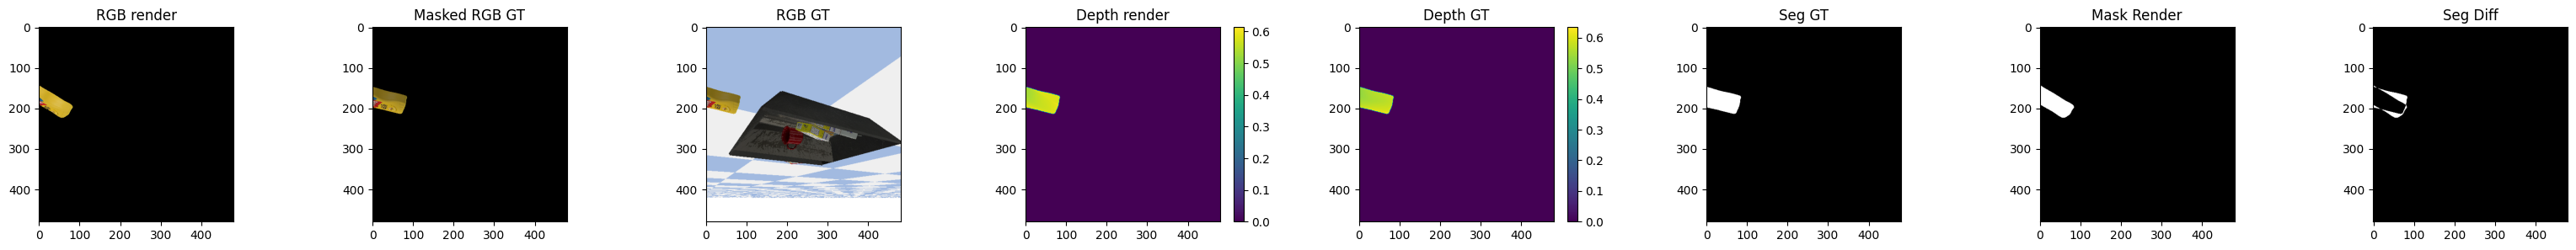

In [44]:
fig,axes = plt.subplots(1,8,figsize=(40,3))
axes[0].set_title('RGB render')
axes[1].set_title('Masked RGB GT')
axes[2].set_title('RGB GT')
axes[3].set_title('Depth render')
axes[4].set_title('Depth GT')
axes[5].set_title("Seg GT")
axes[6].set_title("Mask Render")
axes[7].set_title("Seg Diff")

axes[0].imshow(rgb_render.numpy())
axes[1].imshow((rgb_gt*seg_gt).numpy())
axes[2].imshow(rgb_gt.numpy())
dr = axes[3].imshow((depth_render*seg_gt[...,0]).numpy())
dg = axes[4].imshow((depth_gt*seg_gt[...,0]).numpy())
axes[5].imshow(seg_gt.numpy())
axes[6].imshow(mask.numpy())
axes[7].imshow(diff_mask.numpy())
plt.colorbar(dr,ax=axes[3])
plt.colorbar(dg,ax=axes[4])

#### Glance Losses

### Run Optimization

In [45]:
ddope.run_optimization()
ic(ddope.get_argmin(), ddope.get_pose())
print(f'GT pose:{gt_pose_cam_t44}')

loss: 0.1786: 100%|██████████| 151/151 [00:06<00:00, 24.93it/s]
ic| ddope.get_argmin(): tensor(7)
    ddope.get_pose(): array([[ 0.477243  , -0.56142867, -0.6760452 , -0.30994982],
                             [ 0.2944798 ,  0.82700014, -0.47890764, -0.09380004],
                             [ 0.8279619 ,  0.02947372,  0.5600094 , -0.57904255],
                             [ 0.        ,  0.        ,  0.        ,  1.        ]],
                            dtype=float32)


GT pose:[[ 0.46747209 -0.20330416 -0.86031235 -0.3136427 ]
 [ 0.03853529  0.97695679 -0.20992981 -0.08476402]
 [ 0.88316753  0.06498394  0.46453436 -0.5803759 ]
 [ 0.          0.          0.          1.        ]]


In [46]:
#These are now raw loss values
img_plot = ddope.plot_losses()
cv2.imwrite("plot.png", img_plot)
ddope.make_animation(output_file_path="simple_scene.mp4",batch_index=None)
print("Saved animation to simple_scene.mp4")
opt_results = ddope.optimization_results
#params = ['qx','qy','qz','qw','x','y','z']
params = ['rx','ry','rz','x','y','z']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


making video: 100%|██████████| 151/151 [00:13<00:00, 11.55it/s]


Saved animation to simple_scene.mp4


Best RGB Loss: 0.037358298897743225
GT Raw RGB Loss:0.02856307663023472
--------
Best Depth Loss: 0.0012173105496913195
GT Raw Depth Loss:0.00017798140470404178
--------
GT Raw Mask Loss:0.004298307001590729
Best Mask Loss: 0.04564321041107178


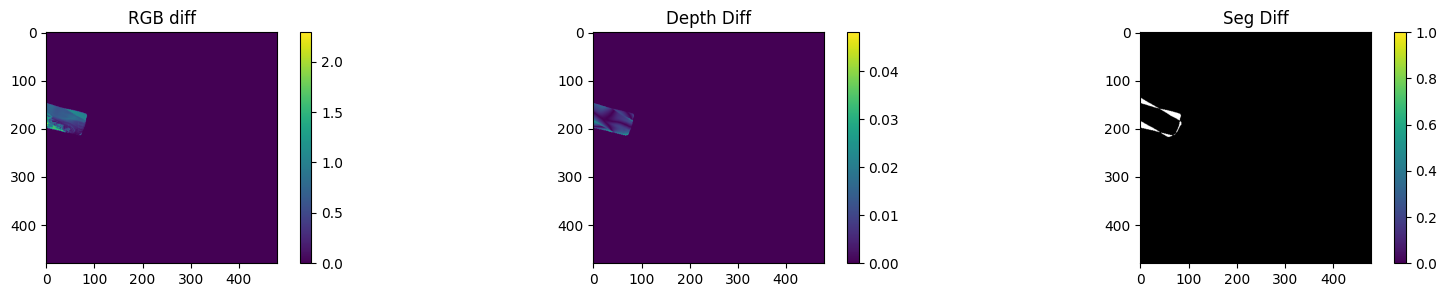

In [47]:
argmi = ddope.get_argmin()
print(f"Best RGB Loss: {ddope.losses_values['rgb'][...,argmi][-1]}")
print(f"GT Raw RGB Loss:{gt_rgb_loss}")
print("--------")
print(f"Best Depth Loss: {ddope.losses_values['depth'][...,argmi][-1]}")
print(f"GT Raw Depth Loss:{gt_depth_loss}")
print("--------")
print(f"GT Raw Mask Loss:{gt_mask_loss}")
print(f"Best Mask Loss: {ddope.losses_values['mask_selection'][...,argmi][-1]}")

best_rgb = ddope.optimization_results[-1]['rgb'][argmi].cuda()
best_depth = ddope.optimization_results[-1]['depth'][argmi].cuda()
diff_rgb = torch.abs(
        (best_rgb - ddope.gt_tensors["rgb"])
        * ddope.gt_tensors["segmentation"]
    )
diff_depth = torch.abs(
        (best_depth - ddope.gt_tensors["depth"])
        * ddope.gt_tensors["segmentation"][..., 0]
    )
mask = best_rgb > 0
mask = mask.to(torch.float32)
diff_mask = torch.abs(mask - ddope.gt_tensors["segmentation"])
fig,axes = plt.subplots(1,3,figsize=(20,3))
axes[0].set_title('RGB diff')
axes[1].set_title('Depth Diff')
axes[2].set_title('Seg Diff')

drgb = axes[0].imshow(diff_rgb[0].sum(-1).cpu().detach().numpy())
dde = axes[1].imshow(diff_depth[0].cpu().detach().numpy())
dm = axes[2].imshow(diff_mask[0].cpu().detach().numpy())

plt.colorbar(drgb,ax=axes[0])
plt.colorbar(dde,ax=axes[1])
plt.colorbar(dm,ax=axes[2])

### Visualize Gradients

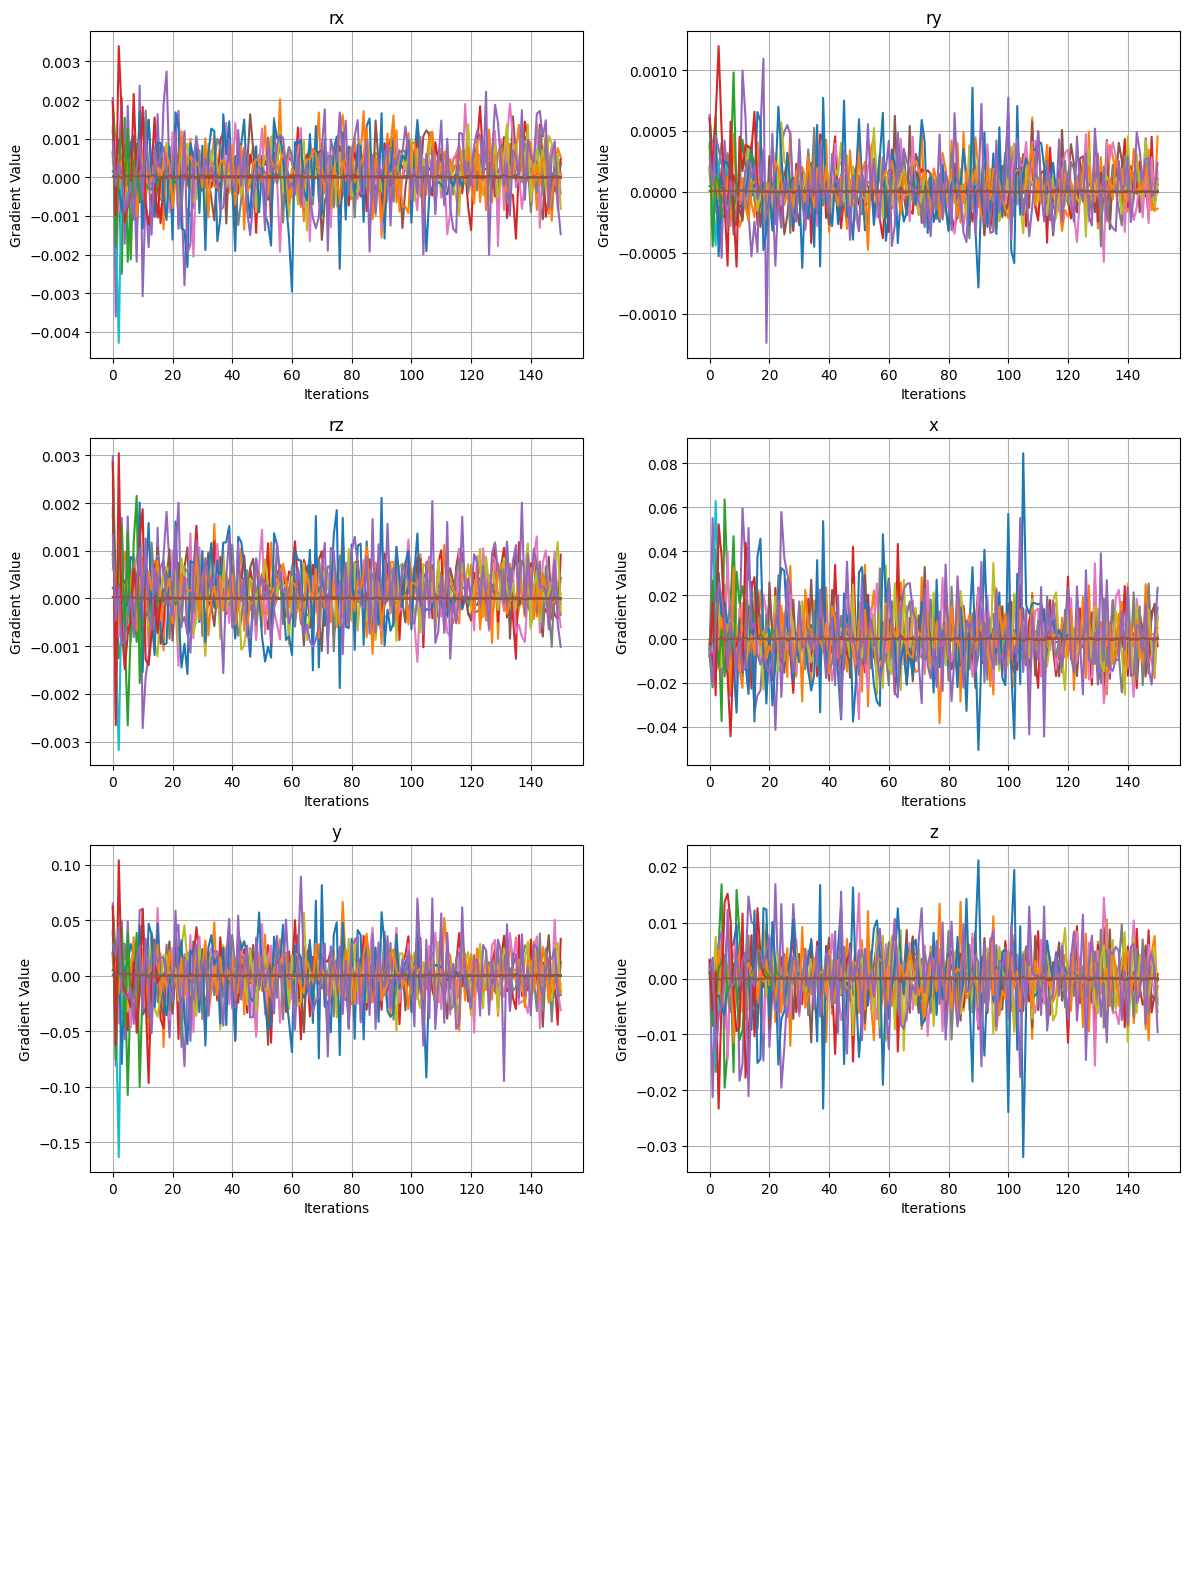

In [48]:
gradients = [o['gradients'].T for o in opt_results]
rows = 4  # Number of rows in the subplot grid
cols = 2 
num_params = len(params)
fig, axs = plt.subplots(rows, cols, figsize=(12, 16))  # Adjust size if needed

for i, ax in enumerate(axs.flatten()):
    if i < num_params:
        param_gradients = [array[:, i] for array in gradients]  # Extract gradients for each parameter
        ax.plot(param_gradients)
        ax.set_title(params[i])
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Gradient Value')
        ax.grid(True)
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()


### Visualize values

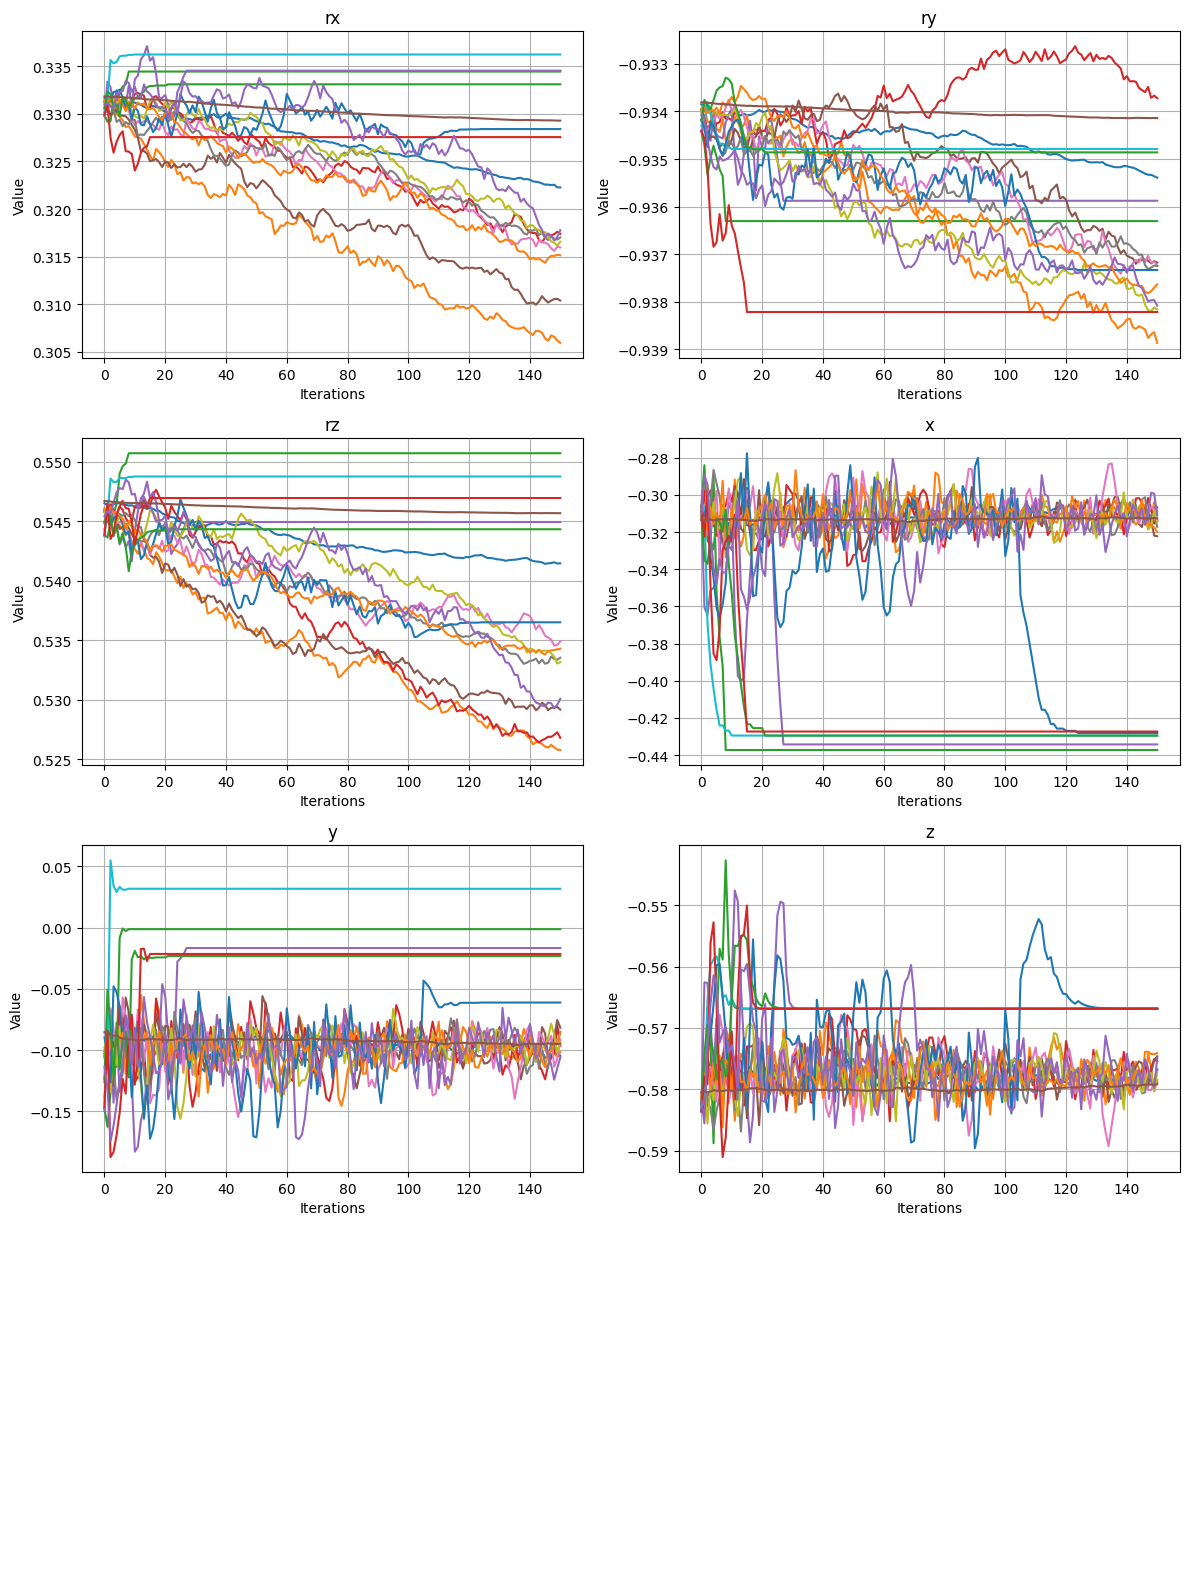

In [49]:
values = [o['values'].T for o in opt_results]
rows = 4  # Number of rows in the subplot grid
cols = 2 
fig, axs = plt.subplots(rows, cols, figsize=(12, 16))  # Adjust size if needed

for i, ax in enumerate(axs.flatten()):
    if i < num_params:
        param_values = np.array([array[:, i] for array in values])  # Extract gradients for each parameter
        means = param_values.mean(1)
        ax.plot(param_values)
        ax.set_title(params[i])
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Value')
        ax.grid(True)
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()
